#Installing Libraries

*   PyTorch version: 1.8 supported by CUDA version: 10.1 (along with torchvision) 
*   Detectron2 compatible with above PyTorch version.



In [1]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 274 kB 11.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=0ba3decba02705ceada52a160dbc8643ce9a68146081b786cae1f890ae2c8fec
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5 MB 15 kB/s 
     |████████████████████████████████| 17.3 MB 988 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Succ

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

#Importing Libraries

In [3]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

###A *function* to convert standard labelme json format observed in Intel IDD Segmentation dataset into COCO format required for Mask-RCNN-ResNet50-FPN model provided by Detectron2. 

Reference to the dataset: 


*   Indian Driving Dataset
*   https://idd.insaan.iiit.ac.in/
*   Dataset Name: IDD Segmentation (IDD 20k Part II) (5.5 GB)


                          
                          

In [4]:
# classes that we require in the IDD dataset.
temp_classes = ['car','bus', 'truck', 'building', 'autorickshaw', 'bridge', 'person', 'traffic light', 'traffic sign', 'motorcycle', 'rider']

def get_coco(directory, classes):
  dataset_dicts = []
  for filename in [file for file in os.listdir(directory) if file.endswith(".json")]:
    json_ = os.path.join(directory, filename)
    with open(json_) as f:
      json_file = json.load(f)

    # single record instance (COCO-JSON instance)
    record = {} 

    image_path = os.path.join(directory, filename[:-5] + ".jpg")

    record["file_name"] = image_path
    record["height"] = json_file["imgHeight"]
    record["width"] = json_file["imgWidth"]

    annotations = json_file["objects"]
    objects = []

    for anno in annotations:
        if anno["label"] in temp_classes:
            px = [a[0] for a in anno["polygon"]]  # x- coordinate of points of the polygon around the object
            py = [a[1] for a in anno["polygon"]]  # y- coordinate of points of the polygon around the object
            poly = [(x, y) for x, y in zip(px, py)] # creating a pool of x and y
            poly = [p for coord in poly for p in coord]   # arranging (x, y), (x, y),... into x, y, x, y, x, y, ...

            # eliminating annotations with improper coordinates (less than or equal to 2)
            if len(poly) <= 4:
              continue

            # we are assuming rider (driver of a motorbike) as a person too
            if anno["label"] == "rider": label = "person"
            # considering one of the class of COCO dataset - motorbike
            elif anno["label"] == "motorcycle": label = "motorbike"
            else: label = anno["label"]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)], # bounding box
                "bbox_mode": BoxMode.XYXY_ABS,                            # bounding box type
                "segmentation": [poly],                                   # segmentation values
                "category_id": classes.index(label),                      # class id
                # iscrowd is 0 for polygon values
                # iscrowd is 1 for RLE - RunTimeEncoding
                "iscrowd": 0
            }

            objects.append(obj)
    record["annotations"] = objects
    dataset_dicts.append(record)
  return dataset_dicts

##Classes considered:
1. Car
2. AutoRickshaw
3. MotorBike
4. Building
5. Bridge
6. Truck
7. Person
8. Bus
9. Traffic light
10. Traffic Sign

In [5]:
# list of classes considered
classes = ['car', 'autorickshaw', 'motorbike', 'building', 'bridge', 'truck', 'person', 'bus', 'traffic light', 'traffic sign']
classes.sort()
print(classes)

['autorickshaw', 'bridge', 'building', 'bus', 'car', 'motorbike', 'person', 'traffic light', 'traffic sign', 'truck']


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive






###Registration of dataset before actually using them. We assign a key for both training and validation data path.

In [ ]:
data_path = '/content/drive/MyDrive/Dataset_IDD/'

for d in ["train"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_coco(data_path+d, classes)
    )
    print(d)
  
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)
   
microcontroller_metadata = MetadataCatalog.get("category_train")

train


###✅ If you want to register again with same key, then first you need to delete the key from DatasetCatalog.

###✅ If you want to set different classes as Metadata for that key, you need to delete that from MetadataCatalog as well.

In [ ]:
# DatasetCatalog.remove("category_test")
DatasetCatalog.remove("category_train")


#Configuration


*   Set the file appropriate model to merge
*   Set the train key
*   Give number of workers for data loading - threads
*   From merged file, assign the model weights
*   If you are running local, then to use the GPU (CUDA), you need assign model device as 'cuda'
*   Set the IMS per batch
*   Set the base learning rate
*   Set the maximum iterations
*   Set the number of foreground classes - RegionOfInterest 



In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

# new config file for training
cfg = get_cfg()
# merging pre trained model config file with the new config file
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# adding our own custom dataset
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
# changing number of workers
cfg.DATALOADER.NUM_WORKERS = 2
# adding pretrained model as model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# number of images per batch taken by a single GPU (or CPU)
cfg.SOLVER.IMS_PER_BATCH = 5
# Learning rate
cfg.SOLVER.BASE_LR = 0.00025
# number of iterations 
cfg.SOLVER.MAX_ITER = 3000
# number of classes we considered
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

In [ ]:
# saving the new config file created for training
# to use it for prediction
with open("output.yaml") as f:
  f.write(cfg.dump())

In [ ]:
!nvidia-smi

#Training



*   Set the path to store the trained model
*   Train the model
 
####Output of below cell shows the entire ResNet50 architecture acting for Mask-RCNN algorithm.

In [ ]:
# assigning output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# creating trainer object based on the created configuration file
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
print(cfg.OUTPUT_DIR)

In [ ]:
# re training the model on our dataset on respective classes

trainer.train()

#Prediction



*   Create new config file for prediction using previous config file and model weights created
*   Set a threshold value for ROI head score
*   Create a predictor object using Default Predictor provided by detectron2


In [7]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import ColorMode, Visualizer

# config file for prediction
cfg = get_cfg()
# merge both the previous config file from training and the current one
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file("/content/drive/MyDrive/new_model/output.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# add the model weights created from training
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/MyDrive/new_model/model_final.pth")
# threshold for detecting objects
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# creation of predictor object based on new config file with retrained neural network and configurations
predictor = DefaultPredictor(cfg)

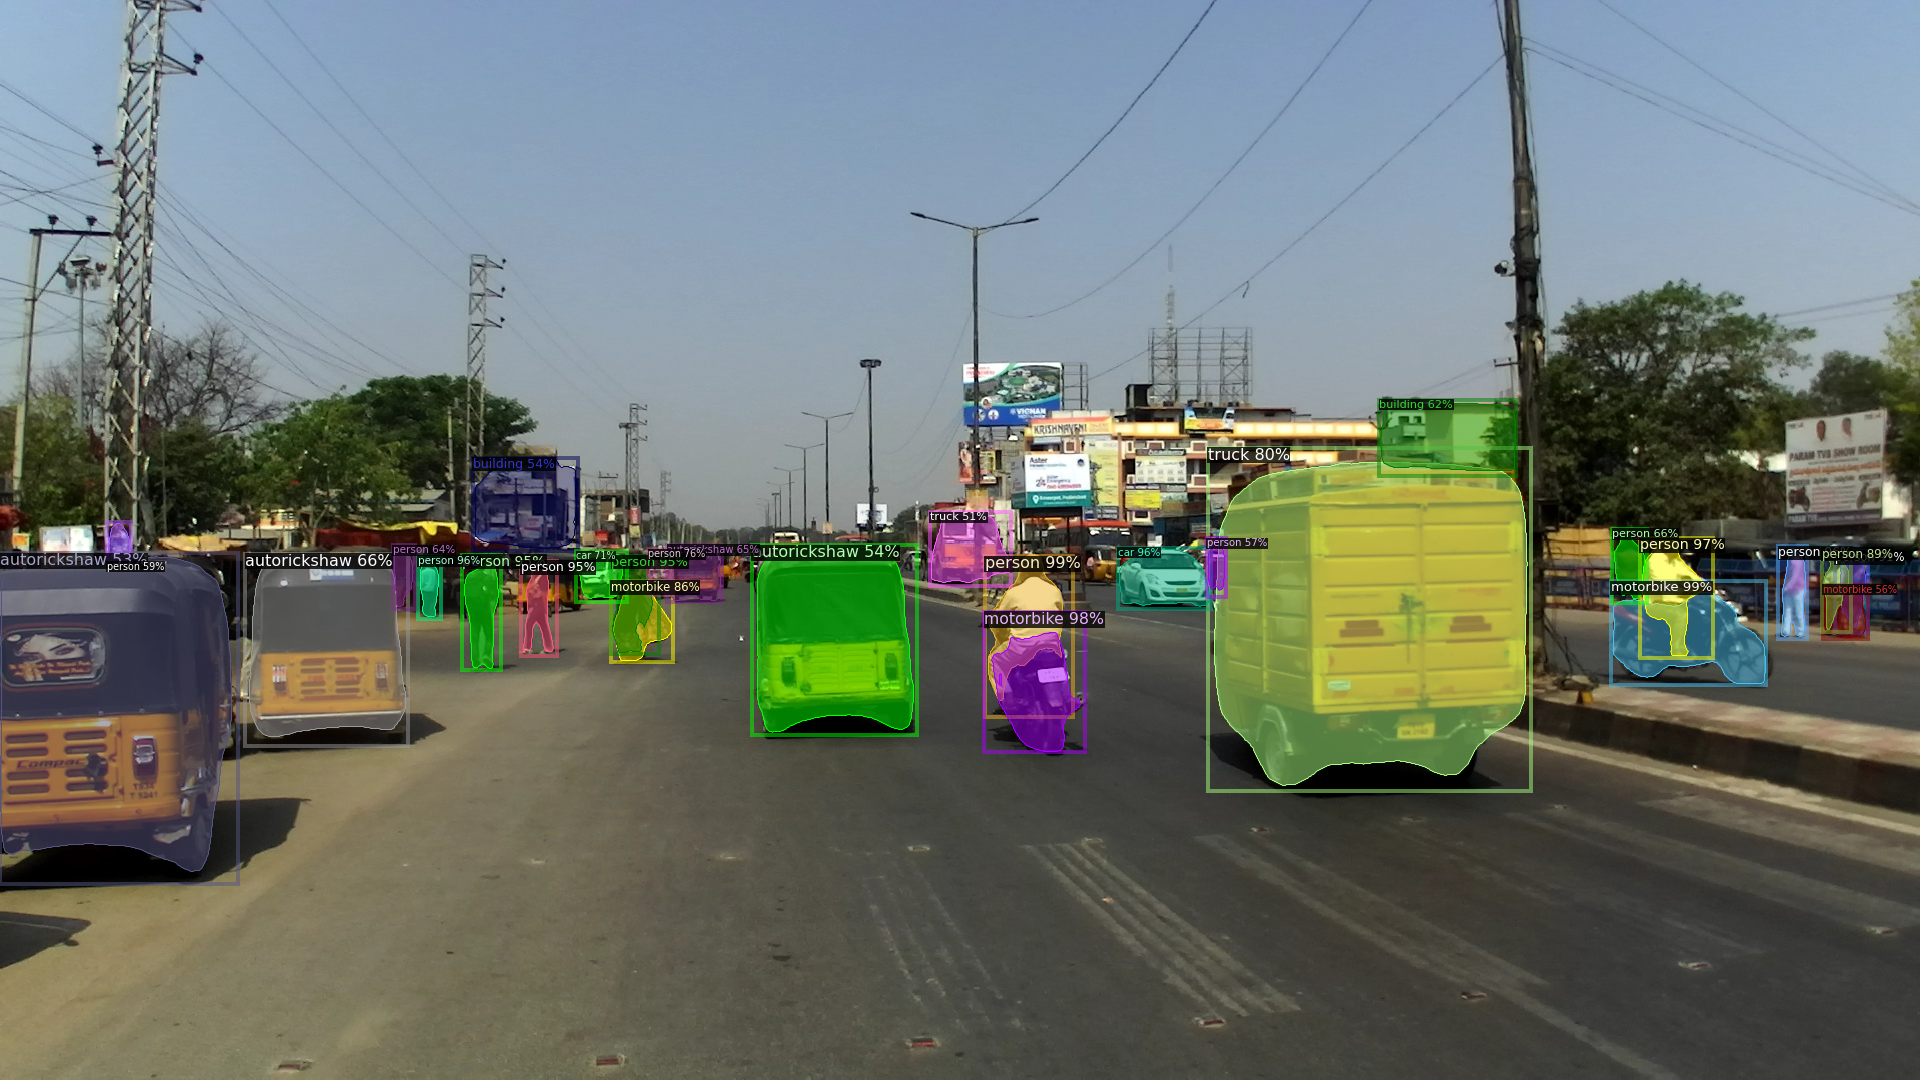

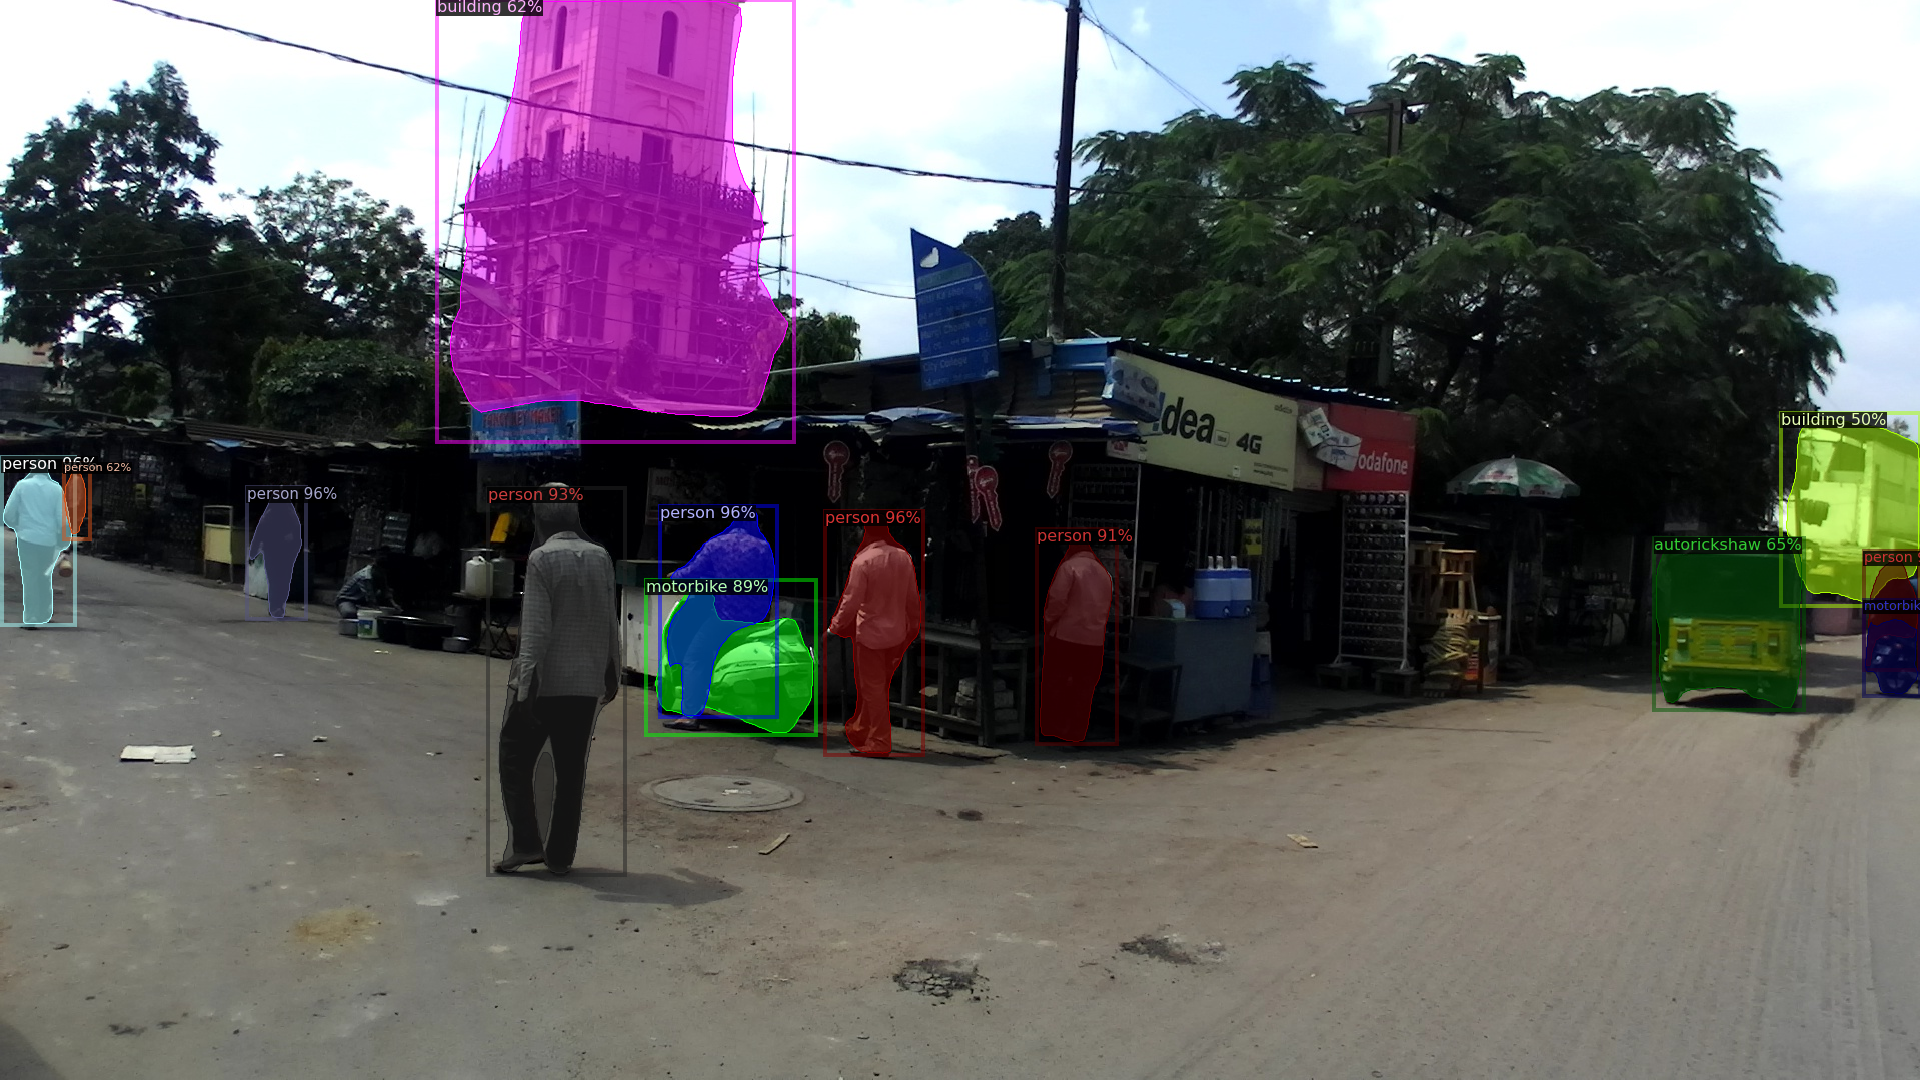

In [58]:
import numpy as np
from google.colab.patches import cv2_imshow

#test with an image
test = ['img.jpg','0608.jpg']
for i in test:
  pathh = '/content/drive/MyDrive/test_data/'
  img = cv2.imread(pathh+i)
  img.shape

  # predicting an image: return object will be of certain format associated with detectron2
  outputs = predictor(img)

  # Note: outputs come in BGR format. It is the reason we are using cv2 for reading the image as cv2 stays with BGR format.

  # creating visualizer object: parameters: Image - (entire row, entire column and 3rd dimension in reverse order - BGR to RGB)
  #                                         Metadata - entire classes
  #                                         Scale - Scaling for the image
  #                                         Instance_mode - Colors associated with the image                                            
  m_data = MetadataCatalog.get("category_train").set(thing_classes = classes)
  v = Visualizer(img[:, :, ::-1],
                metadata = m_data, 
                scale = 1, 
                instance_mode = ColorMode.SEGMENTATION # removes the colors of unsegmented pixels
    )

  # Drawing the prediction instances on the image based on the outputs generated
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

  # Note: Certainly, process will use GPU - CUDA for prediction also. To leave the work on GPU, we can use CPU for prediction using .to('cpu)

  # again converting RGB to BGR as cv2 supports BGR formats
  img = v.get_image()[:, :, ::-1]
  # we are using cv2_imshow from google colab patches as original cv2.imshow won't in both jupyter notebook and google colab (.ipynb)
  cv2_imshow(img)

###Handling the images with grid

In [59]:
# we can use the outputs format for every output criteria we can use
# classes detected in the image
classes_detected = outputs['instances'].pred_classes
print(classes)
print(classes_detected)
# creating a dictionary for every class detected
dic ={}
classes_detected = classes_detected.tolist()
set_detected = list(set(classes_detected))
print(set_detected)
for i in range(len(set_detected)):
  dic[set_detected[i]] = []
dic


['autorickshaw', 'bridge', 'building', 'bus', 'car', 'motorbike', 'person', 'traffic light', 'traffic sign', 'truck']
tensor([5, 6, 6, 6, 6, 6, 6, 6, 5, 0, 2, 6, 2], device='cuda:0')
[0, 2, 5, 6]


{0: [], 2: [], 5: [], 6: []}

In [60]:
# this is a function to get partitions that we can apply based on the image resolution
# it is generic to some extent for most of the image resolutions
def get_partitions(img, dim):
  dims = [3, 4, 5, 6]
  partitions = []
  for i in range(len(dims)):
    if dim % dims[i] == 0:
      division = dims[i]
      gap = dim // dims[i]
      for j in range(dims[i] + 1):
        partitions.append(gap * j)
      partitions[-1] -= 1
      return partitions, division
print(get_partitions(img, 500))
print(get_partitions(img, 850))

([0, 125, 250, 375, 499], 4)
([0, 170, 340, 510, 680, 849], 5)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


(9,)


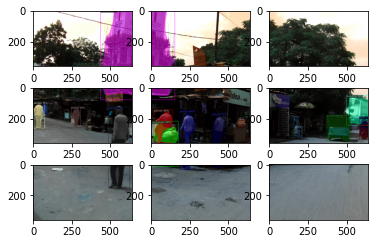

In [61]:
import cv2

# converting image to grid image
def img2grid(img):
  h, w, channels = img.shape
  x,rows = get_partitions(img, h)
  y,columns = get_partitions(img, w)
  #plt.imshow(img)
  grid = []
  for i in range(len(x) - 1):
    for j in range(len(y) - 1):
      grid.append(img[x[i]: x[i+1], y[j]: y[j+1]])
  grid = np.array(grid)
  return grid, rows, columns

# getting grid numbers and rows and columns partitioned
grid_no=0
grid, rows, columns = img2grid(img)
print(grid.shape)
for i in range(rows):
  for j in range(columns):
    # plotting the images into subplots
    plt.subplot(rows, columns, grid_no+1)
    plt.imshow(grid[grid_no])
    grid_no += 1

plt.show()

In [62]:
# manipulating the mask array based on requirement
mask_array = outputs['instances'].pred_masks.to('cpu').numpy()
print(mask_array.shape)
mask_array = np.moveaxis(mask_array, 0, -1)
print(mask_array.shape)
mask_array_instance = []
output = np.zeros_like(img)
print(output.shape)

(13, 1080, 1920)
(1080, 1920, 13)
(1080, 1920, 3)


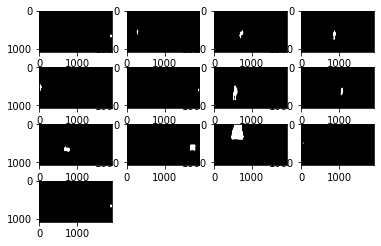

In [63]:
import math
# for reference, printing every mask that is predicted
for i in range(len(classes_detected)):
  output = np.zeros_like(img) #black
  div = math.sqrt(len(classes_detected)) + 1
  plt.subplot(div, div, i+1)
  mask_array_instance.append(mask_array[:, :, i:(i+1)])
  plt.imshow(np.where(mask_array_instance[i] == True, 255, output))

plt.imshow(np.where(mask_array_instance[0] == True, 255, output))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


{'autorickshaw': [5], 'building': [0, 1, 3, 4, 5], 'motorbike': [4, 5, 7], 'person': [3, 4, 5, 6, 7]}
(9,)


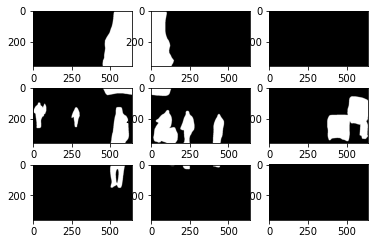

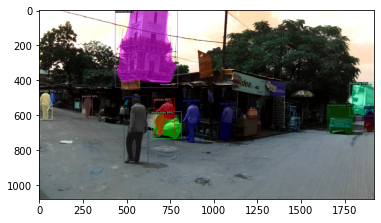

In [66]:
complete_img = np.zeros_like(img)
for i in range(len(classes_detected)):
  output = np.zeros_like(img) #black
  complete_img = np.where(mask_array_instance[i] == True, 255, complete_img)

  mask_array_instance.append(mask_array[:, :, i:(i+1)])
  
  output = np.where(mask_array_instance[i] == True, 255, output)
  
  grids_array,rows,columns = img2grid(output)
   # plt.imshow(grid_array[0])
  grid = grids_array
  grid_no=0
  total_area = columns*rows
  for x in range(rows):
    for y in range(columns):

        #converting 3d image to 2d grayscale
      grids_array[grid_no] = grids_array[grid_no][:,:,0]
        #2d to 1d 
      flat_list = list(grids_array[grid_no].flatten())

      count = flat_list.count(255.0)
      if (count/total_area)>0.2:
        dic[classes_detected[i]].append(grid_no)
      grid_no+=1

result = {}
for clas in dic.keys():
  result[classes[clas]] = list(set((dic[clas])))
print(result)

grid_no=0
grid,rows,columns = img2grid(complete_img)
print(grid.shape)
for i in range(rows):
  for j in range(columns):
    plt.subplot(rows,columns,grid_no+1)
    plt.imshow(grid[grid_no])
    grid_no+=1
plt.show()
plt.imshow(img)

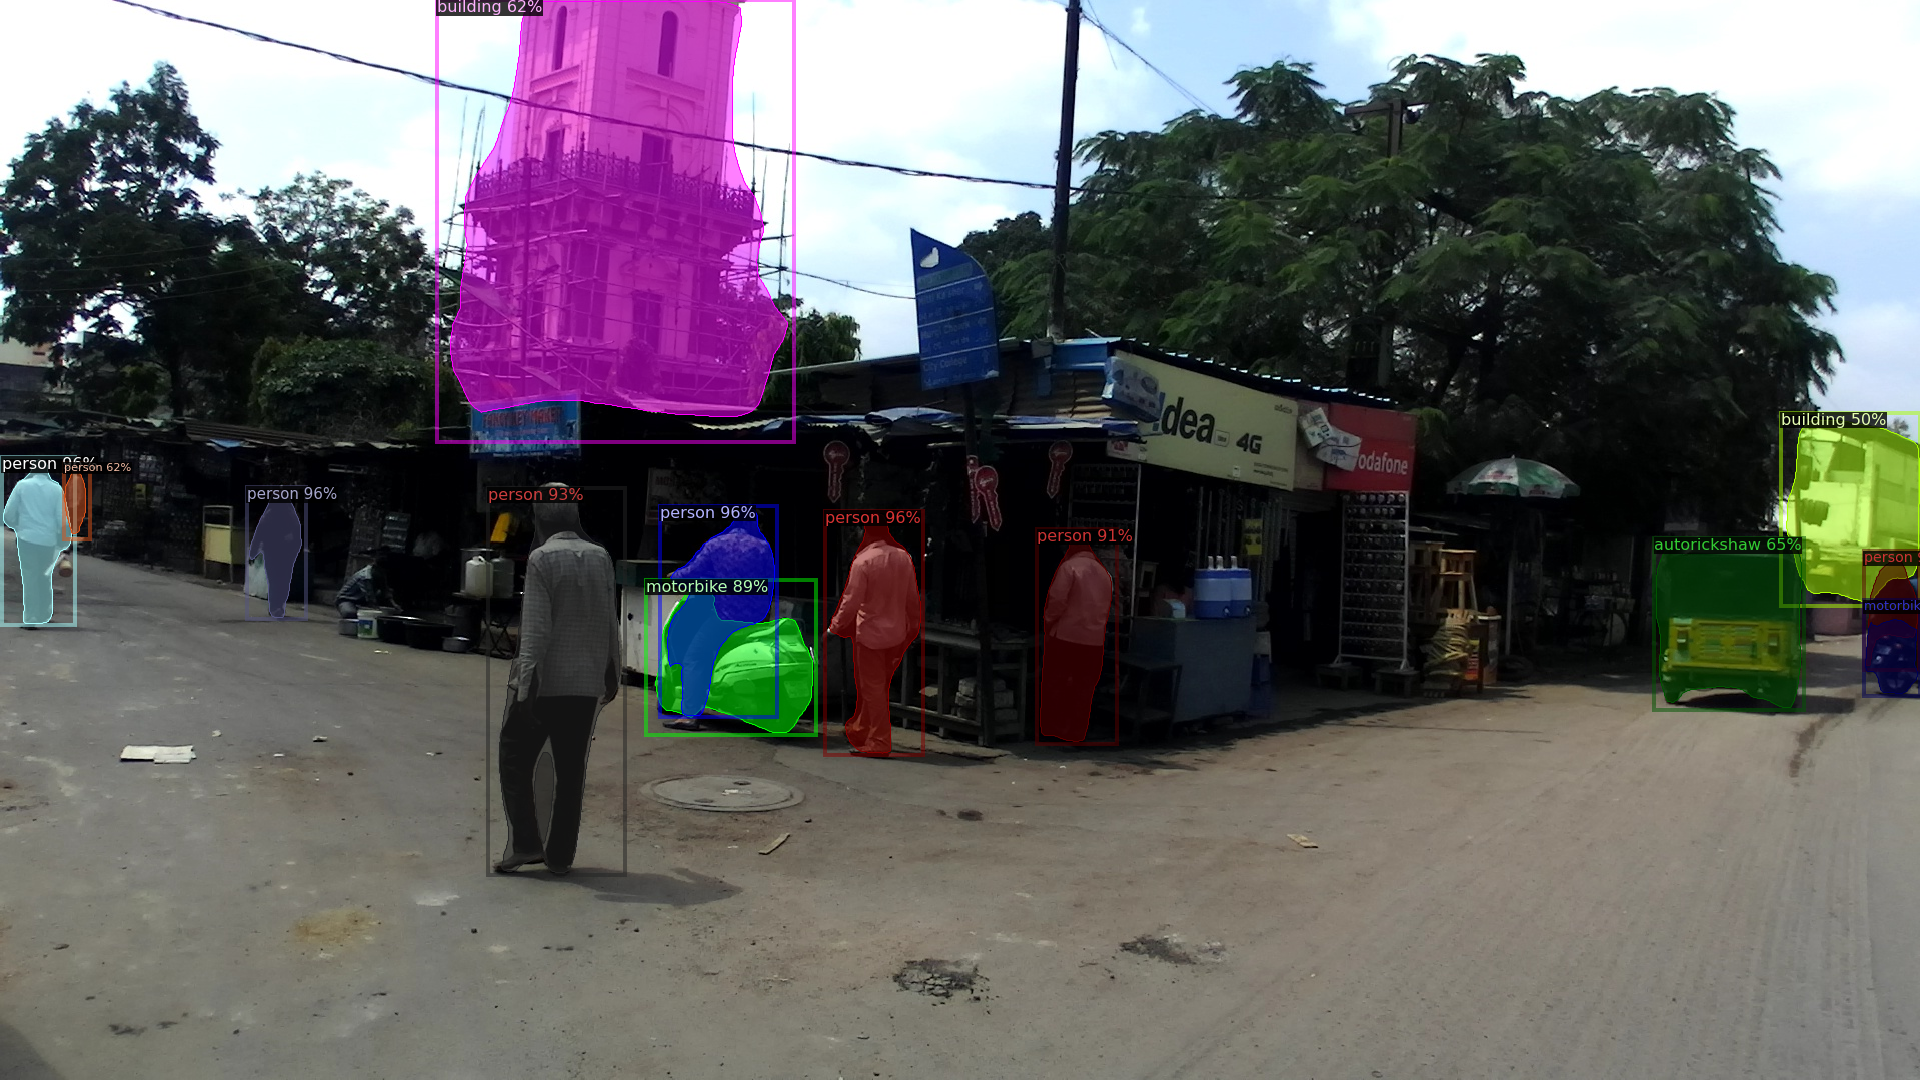

In [67]:
cv2_imshow(img)